# 클릭 로그 기반 Hybrid Recommender System: Content-based, Collaborative Filtering

작성일자 : 2024-01-21

작성자 : [Data Scientist] 민희수


### **Problem**
번개장터의 클릭 로그를 활용하여 하이브리드 기반 추천 알고리즘을 적용하고, 해당 추천 결과를 확인합니다. 더불어, 협업 필터링 기반의 Neural Collaborative Filtering (NCF) 모델에 대한 결과도 살펴봅니다.
### **Process**
1. 데이터셋 확인
2. EDA
3. Visualizing the Data
4. Data Cleansing
5. Modeling + Result

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Import Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
import re

import plotly.express as px
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

## 1. 데이터셋 확인
- content_id : 상품 ID
- content_type : 상품 타입 (product로 통일)
- server_time_kst : 데이터가 기록된 시간
- user_id : 클릭한 사용자 ID
- device_type : 클릭한 디바이스 (a; 안드로이드, i; iOS, w; PC Web, m: 모바일 웹)
- session_id : 세션 ID
- content_owner : 상품을 등록한 사용자 ID
- ref_term : 검색을 통해 클릭한 상품인 경우, 경유 검색어
- name : 상품 이름
- keyword : 상품 태그
- category_id : 카테고리 ID
- category_name : 카테고리 이름
- image_url : 상품 이미지 URL


In [68]:
# Load data
PROJECT_FILE = "/content/gdrive/MyDrive/data/rec-exam.parquet"

df = pd.read_parquet(PROJECT_FILE, engine='pyarrow')

print(df.shape)

df.head()

(3324132, 13)


content_id content_type                server_time_kst   user_id  \
0  138933030      product  2020-12-07T22:43:23.879+09:00  10000288   
1  139850819      product  2020-12-07T22:43:49.605+09:00  10000288   
2  134550780      product  2020-12-07T22:44:31.585+09:00  10000288   
3  138289348      product  2020-12-07T22:45:11.506+09:00  10000288   
4  138738902      product  2020-12-07T22:45:55.510+09:00  10000288   

  device_type         session_id content_owner ref_term  \
0           i  1607348537-dhOQi3       4424970     None   
1           i  1607348537-dhOQi3      10254112     None   
2           i  1607348537-dhOQi3       7990230     None   
3           i  1607348537-dhOQi3       4590468     None   
4           i  1607348537-dhOQi3      11472514     None   

                            name  \
0                 삼성 탭s2 8.0 팝니다   
1  [수능끝] 새 문제집 판매 (메가스터디, 마닳 등등)   
2              아이나비탭 xd duo 10 s   
3         아이패드 6세대 + 애플펜슬 1세대 일괄   
4          급처) 아이패드 미니5  스그 wifi   

                                        keyword category_id category_name  \
0                                          None   600700004           태블릿   
1                    문제집정리,문제집새거,문제집판매,문과문제집,문과   900100004     학습/사전/참고서   
2           아이나비탭,태블릿노트북,2in1노트북,윈도우10,윈도우태블릿pc   600700004           태블릿   
3  아이패드6세대로골,아이패드프로4실버,애플펜슬1세대,아이폰6플러스,태블릿노트북맥북   600700004           태블릿   
4                            미니5,64,와이파이,싼가격,미니   600700004           태블릿   

                                           image_url  
0  https://media.bunjang.co.kr/product/138933030_...  
1  https://media.bunjang.co.kr/product/139850819_...  
2  https://media.bunjang.co.kr/product/134550780_...  
3  https://media.bunjang.co.kr/product/138289348_...  
4  https://media.bunjang.co.kr/product/138738902_...

In [69]:
# Change string to int
df.loc[df['device_type'] == 'a', 'device_type'] = 1
df.loc[df['device_type'] == 'i', 'device_type'] = 2
df.loc[df['device_type'] == 'w', 'device_type'] = 3
df.loc[df['device_type'] == 'm', 'device_type'] = 4

In [70]:
# Change object to int
df['content_id'] = df['content_id'].astype(int)
df['user_id'] = df['user_id'].astype(int)
df['category_id'] = df['category_id'].astype(int)
df['device_type'] = df['device_type'].astype(int)

In [55]:
# RAM 문제로 자르기
# df = df[df['content_id'] < 105099005]

In [71]:
# Change datetime
from datetime import datetime, timezone, timedelta

def convert_to_timestamp(date_string):
    dt_object = datetime.fromisoformat(date_string)
    dt_object_utc = dt_object.astimezone(timezone.utc)
    return dt_object_utc.timestamp()

df['timestamp'] = df['server_time_kst'].apply(convert_to_timestamp)
df['server_time_kst'] = pd.to_datetime(df.server_time_kst)

In [156]:
df

content_id content_type                  server_time_kst   user_id  \
0         138933030      product 2020-12-07 22:43:23.879000+09:00  10000288   
1         139850819      product 2020-12-07 22:43:49.605000+09:00  10000288   
2         134550780      product 2020-12-07 22:44:31.585000+09:00  10000288   
3         138289348      product 2020-12-07 22:45:11.506000+09:00  10000288   
4         138738902      product 2020-12-07 22:45:55.510000+09:00  10000288   
...             ...          ...                              ...       ...   
3324127   129226416      product 2020-12-07 23:36:54.355000+09:00   9999846   
3324128   134099005      product 2020-12-07 23:36:58.518000+09:00   9999846   
3324129   132208654      product 2020-12-07 23:37:15.986000+09:00   9999846   
3324130   131577857      product 2020-12-07 22:49:35.233000+09:00   9999992   
3324131   131577857      product 2020-12-07 22:49:43.635000+09:00   9999992   

         device_type         session_id content_owner ref_term  \
0                  2  1607348537-dhOQi3       4424970     None   
1                  2  1607348537-dhOQi3      10254112     None   
2                  2  1607348537-dhOQi3       7990230     None   
3                  2  1607348537-dhOQi3       4590468     None   
4                  2  1607348537-dhOQi3      11472514     None   
...              ...                ...           ...      ...   
3324127            1  1607351766-RDilcO          None    방탄 제본   
3324128            1  1607351766-RDilcO          None    방탄 제본   
3324129            1  1607351766-RDilcO          None    방탄 제본   
3324130            2  1607348960-TWD90B       9999992     None   
3324131            2  1607348960-TWD90B       9999992     None   

                                  name  \
0                       삼성 탭s2 8.0 팝니다   
1        [수능끝] 새 문제집 판매 (메가스터디, 마닳 등등)   
2                    아이나비탭 xd duo 10 s   
3               아이패드 6세대 + 애플펜슬 1세대 일괄   
4                급처) 아이패드 미니5  스그 wifi   
...                                ...   
3324127                          방탄 제본   
3324128           방탄 방탄소년단 제본 태영님 책 양도   
3324129                   방탄 빙의글 제본 판매   
3324130                넨도로이드 피규어 (170)   
3324131                넨도로이드 피규어 (170)   

                                              keyword  category_id  \
0                                                None    600700004   
1                          문제집정리,문제집새거,문제집판매,문과문제집,문과    900100004   
2                 아이나비탭,태블릿노트북,2in1노트북,윈도우10,윈도우태블릿pc    600700004   
3        아이패드6세대로골,아이패드프로4실버,애플펜슬1세대,아이폰6플러스,태블릿노트북맥북    600700004   
4                                  미니5,64,와이파이,싼가격,미니    600700004   
...                                               ...          ...   
3324127                                     방탄,빙의글,제본    910100007   
3324128                                      방탄,방탄소년단    910100007   
3324129                          방탄소년단,빙의글,제본,소장본,BTS    910100007   
3324130                                         넨도로이드    900320100   
3324131                                         넨도로이드    900320100   

        category_name                                          image_url  \
0                 태블릿  https://media.bunjang.co.kr/product/138933030_...   
1           학습/사전/참고서  https://media.bunjang.co.kr/product/139850819_...   
2                 태블릿  https://media.bunjang.co.kr/product/134550780_...   
3                 태블릿  https://media.bunjang.co.kr/product/138289348_...   
4                 태블릿  https://media.bunjang.co.kr/product/138738902_...   
...               ...                                                ...   
3324127      기타(보이그룹)  https://media.bunjang.co.kr/product/129226416_...   
3324128      기타(보이그룹)  https://media.bunjang.co.kr/product/134099005_...   
3324129      기타(보이그룹)  https://media.bunjang.co.kr/product/132208654_...   
3324130        피규어/인형  https://media.bunjang.co.kr/product/131577857_...   
3324131        피규어/인형  https://media.bunjang.co.kr/product/131577857_...   

        

## 2. Visualizing the Data

In [ ]:
n_df = len(df)
n_content = len(df['content_id'].unique())
n_users = len(df['user_id'].unique())

print(f"Number of data : {n_df}")
print(f"Number of unique content's : {n_content}")
print(f"Number of unique users : {n_users}")
print(f"Average ratings per user : {round(n_df/n_users, 2)}")
print(f"Average ratings per content : {round(n_df/n_content, 2)}")

Number of data : 3324132
Number of unique content's : 1322891
Number of unique users : 226790
Average ratings per user : 14.66
Average ratings per content : 2.51


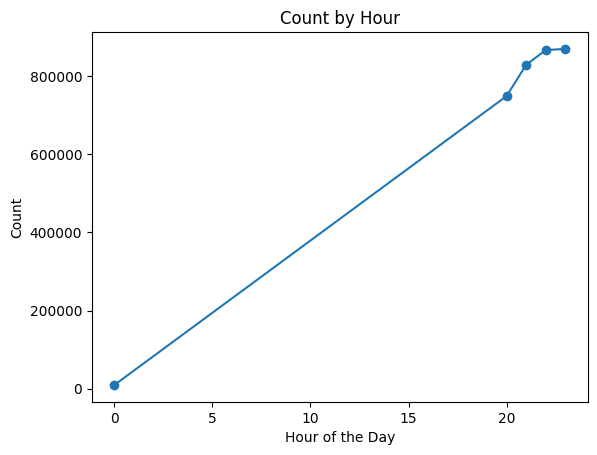

In [ ]:
# 시간별 cnt
result = df.groupby(df['server_time_kst'].dt.hour).size()

result.plot(kind='line', marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Count')
plt.title('Count by Hour')
plt.show()

<Axes: >

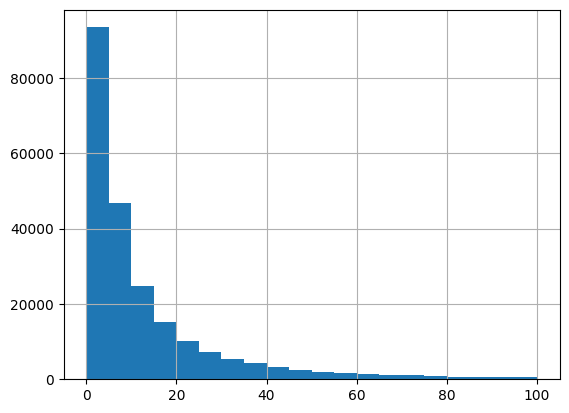

In [ ]:
# 각 user별 상품 개수
cnt_per_user = df.groupby('user_id')['content_id'].count()
statistics.mean(cnt_per_user.tolist())

cnt_per_user.hist(bins=20, range=(0,100))

<Axes: >

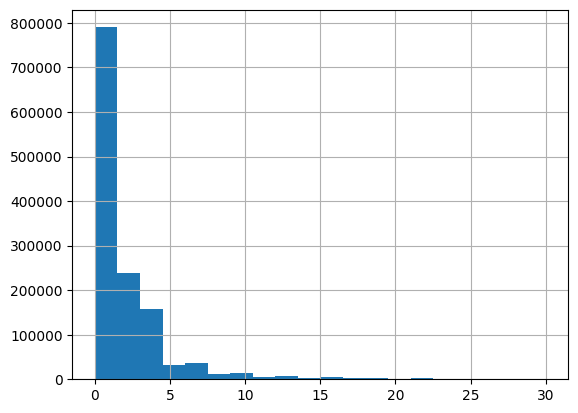

In [ ]:
# 각 상품별 개수
cnt_per_content = df.groupby('content_id')['content_id'].count()
statistics.mean(cnt_per_content.tolist())

cnt_per_content.hist(bins=20, range=(0,30))

In [ ]:
# category 별 분포
category = df[['category_id','category_name']].value_counts()

cg_index = []
for i in category.index:
    cg_index.append(np.array(i))
cg_index = np.array(cg_index)

cdf = pd.DataFrame(columns=['category_id','category_name','values'])
cdf['category_id'] = cg_index[:,0]
cdf['category_name'] = cg_index[:,1]
cdf['values'] = category.values

px.bar(data_frame=cdf, x='category_name', y='values', color='category_id')

In [ ]:
ref_term_ = df.groupby(by='ref_term').count()
ref_term_

content_id  content_type  server_time_kst  user_id  \
ref_term                                                            
  275  35  19           6             6                6        6   
  나이키250                4             4                4        4   
  모니터                   6             6                6        6   
  자판기                   4             4                4        4   
  젤다야숨                  5             5                5        5   
...                   ...           ...              ...      ...   
힙합시계                    2             2                2        2   
힙합앨범                   22            22               22       22   
힛탠다드                    2             2                2        2   
💚윈윈                     4             4                4        4   
😌맥북에어                   1             1                1        1   

               device_type  session_id  content_owner  name  keyword  \
ref_term                                                               
  275  35  19            6           6              0     6        4   
  나이키250                 4           4              0     4        4   
  모니터                    6           6              0     6        6   
  자판기                    4           4              0     4        3   
  젤다야숨                   5           5              0     5        2   
...                    ...         ...            ...   ...      ...   
힙합시계                     2           2              0     2        1   
힙합앨범                    22          22             22    22       18   
힛탠다드                     2           2              0     2        2   
💚윈윈                      4           4              4     4        3   
😌맥북에어                    1           1              1     1        1   

               category_id  category_name  image_url  
ref_term                                              
  275  35  19            6              6          6  
  나이키250                 4              4          4  
  모니터                    6              6          6  
  자판기                    4              4          4  
  젤다야숨                   5              5          5  
...                    ...            ...        ...  
힙합시계                     2              2          2  
힙합앨범                    22             22         22  
힛탠다드                     2              2          2  
💚윈윈                      4              4          4  
😌맥북에어                    1              1          1  

[127243 rows x 12 columns]

In [ ]:
df["ref_term"].value_counts().rename_axis('unique_values').reset_index(name='counts')

unique_values  counts
0             에어팟 프로    5281
1               오토바이    3426
2               아이패드    3394
3             스톤아일랜드    3269
4                아이폰    3122
...              ...     ...
127238         라니앤쇼룸       1
127239   frank ocean       1
127240     다이아몬드 라이라       1
127241         아노블리어       1
127242       온앤오프 사될       1

[127243 rows x 2 columns]

In [ ]:
keyword_ = df.groupby(by='keyword').count()
keyword_

content_id  content_type  \
keyword                                                                 
!!!                                                   1             1   
!!신축빌라!!(                                             1             1   
"                                                     9             9   
#280,285                                              4             4   
#32인치모니터#27인치게이밍#24인치중고모니터#32인치커브드#144헤르츠HZ           8             8   
...                                                 ...           ...   
🔥모배계정급처?                                              2             2   
😆                                                     1             1   
😊,F                                                   2             2   
🛒🛒 2020                                               1             1   
🤣                                                     2             2   

                                             server_time_kst  user_id  \
keyword                                                                 
!!!                                                        1        1   
!!신축빌라!!(                                                  1        1   
"                                                          9        9   
#280,285                                                   4        4   
#32인치모니터#27인치게이밍#24인치중고모니터#32인치커브드#144헤르츠HZ                8        8   
...                                                      ...      ...   
🔥모배계정급처?                                                   2        2   
😆                                                          1        1   
😊,F                                                        2        2   
🛒🛒 2020                                                    1        1   
🤣                                                          2        2   

                                             device_type  session_id  \
keyword                                                                
!!!                                                    1           1   
!!신축빌라!!(                                              1           1   
"                                                      9           9   
#280,285                                               4           4   
#32인치모니터#27인치게이밍#24인치중고모니터#32인치커브드#144헤르츠HZ            8           8   
...                                                  ...         ...   
🔥모배계정급처?                                               2           2   
😆                                                      1           1   
😊,F                                                    2           2   
🛒🛒 2020                                                1           1   
🤣                                                      2           2   

                                             content_owner  ref_term  name  \
keyword                                                                      
!!!                                                      0         1     1   
!!신축빌라!!(                                                1         1     1   
"                                                        3         4     9   
#280,285                                                 4         4     4   
#32인치모니터#27인치게이밍#24인치중고모니터#32인치커브드#144헤르츠HZ              2         5     8   
...                                                    ...       ...   ...   
🔥모배계정급처?                                                 1         2     2   
😆                                                        1         0     1   
😊,F                                                      2         2     2   
🛒🛒 2020                                                  0         1     1   
🤣                                                        1         2     2   

                                             category_id  category_name  \
keyword                                                                   
!!!                                        

In [ ]:
df["keyword"].value_counts().rename_axis('unique_values').reset_index(name='counts')

unique_values  counts
0                                프리    4243
1                                 L    4067
2                                 m    3834
3                              free    3347
4                                55    3299
...                             ...     ...
1017284  브론슨,버즈릭슨,브론슨셔츠,샴브레이,샴브레이셔츠       1
1017285   레드윙270,목토부츠,8인치,워크웨어,아메카지       1
1017286        스위스밀리터리,발열조끼,온열조끼,광고       1
1017287    280,레드윙,레드윙2935,워커,레드윙부츠       1
1017288         슬링백,플랫,하이힐,미들힐,블로퍼힐       1

[1017289 rows x 2 columns]

In [ ]:
name_ = df.groupby(by='name').count()
name_

content_id  content_type  \
name                                                               
!  AAA급 ! 갤럭시노트9 512GB 퍼플 /1202                  4             4   
!  MS당일배송 ! 구찌 시그니처 삼선 반 지갑 # 루이비통 고야드           1             1   
! (가격내림, 급처) 트리곤 다크니스 sl3 판매 한정판 !              19            19   
! AAA급 ! 갤럭시A31 64GB 블루 /1203                    4             4   
! AAA급 ! 갤럭시A퀀텀 128GB 블랙 /1205                   3             3   
...                                            ...           ...   
🧸무선 초음파 키재기                                      1             1   
🧸정품, 새상품 20SS 발렌시아가 백뉴로고니트🧸                      1             1   
🧸한밤타로🧸재방문 하고 싶은 타로/ 가성비 타로                       1             1   
🧸🧸타미 윈드브레이커🧸🧸                                    1             1   
🪐도형 스티커🪐                                         1             1   

                                        server_time_kst  user_id  device_type  \
name                                                                            
!  AAA급 ! 갤럭시노트9 512GB 퍼플 /1202                       4        4            4   
!  MS당일배송 ! 구찌 시그니처 삼선 반 지갑 # 루이비통 고야드                1        1            1   
! (가격내림, 급처) 트리곤 다크니스 sl3 판매 한정판 !                   19       19           19   
! AAA급 ! 갤럭시A31 64GB 블루 /1203                         4        4            4   
! AAA급 ! 갤럭시A퀀텀 128GB 블랙 /1205                        3        3            3   
...                                                 ...      ...          ...   
🧸무선 초음파 키재기                                           1        1            1   
🧸정품, 새상품 20SS 발렌시아가 백뉴로고니트🧸                           1        1            1   
🧸한밤타로🧸재방문 하고 싶은 타로/ 가성비 타로                            1        1            1   
🧸🧸타미 윈드브레이커🧸🧸                                         1        1            1   
🪐도형 스티커🪐                                              1        1            1   

                                        session_id  content_owner  ref_term  \
name                                                                          
!  AAA급 ! 갤럭시노트9 512GB 퍼플 /1202                  4              1         0   
!  MS당일배송 ! 구찌 시그니처 삼선 반 지갑 # 루이비통 고야드           1              0         0   
! (가격내림, 급처) 트리곤 다크니스 sl3 판매 한정판 !              19             10         1   
! AAA급 ! 갤럭시A31 64GB 블루 /1203                    4              1         1   
! AAA급 ! 갤럭시A퀀텀 128GB 블랙 /1205                   3              0         0   
...                                            ...            ...       ...   
🧸무선 초음파 키재기                                      1              0         1   
🧸정품, 새상품 20SS 발렌시아가 백뉴로고니트🧸                      1              0         1   
🧸한밤타로🧸재방문 하고 싶은 타로/ 가성비 타로                       1              0         0   
🧸🧸타미 윈드브레이커🧸🧸                                    1              1         1   
🪐도형 스티커🪐                                         1              1         0   

                                        keyword  category_id  category_name  \
name                                                                          
!  AAA급 ! 갤럭시노트9 512GB 퍼플 /1202               4            4              4   
!  MS당일배송 ! 구찌 시그니처 삼선 반 지갑 # 루이비통 고야드        1            1              1   
! (가격내림, 급처) 트리곤 다크니스 sl3 판매 한정판 !           19           19             19   
! AAA급 ! 갤럭시A31 64GB 블루 /1203                 4            4              4   
! AAA급 ! 갤럭시A퀀텀 128GB 블랙 /1205                3            3              3   
...                                         ...          ...            ...   
🧸무선 초음파 키재기                                   1            1              1   
🧸정품, 새상품 20SS 발렌시아가 백뉴로고니트🧸                   1            1              1   
🧸한밤타로🧸재방문 하고 싶은 타로/ 가성비 타로                    1            1              1   
🧸🧸타미 윈드브레이커🧸🧸                                 1            1              1   
🪐도형 스티커🪐                                      1            1              1   

                                        image

In [ ]:
df["name"].value_counts().rename_axis('unique_values').reset_index(name='counts')

unique_values  counts
0                              에어팟 프로    2957
1                               에어팟프로    1890
2                            파라점퍼스 고비    1475
3                           디스커버리 숏패딩    1376
4                          에어팟 프로 미개봉    1324
...                               ...     ...
1162143               배스킨라빈스 케이크 기프티콘       1
1162144         배스킨라빈스 아이스크림 케이크 팔아요!       1
1162145  Y3 YOHJI YAMAMOTO 남자스니커즈 260       1
1162146       필라fila 메로나 콜라보 스니커즈/250       1
1162147            [FREE] 밍크수면잠옷/상하셋트       1

[1162148 rows x 2 columns]

In [ ]:
category_ = df.groupby(by='category_name').count()
category_

content_id  content_type  server_time_kst  user_id  \
category_name                                                       
(구)가방/지갑               83            83               83       83   
(구)남성의류                76            76               76       76   
(구)신발                 332           332              332      332   
(구)여성의류                 8             8                8        8   
(구)쥬얼리/시계              20            20               20       20   
...                   ...           ...              ...      ...   
후드 티셔츠              35367         35367            35367    35367   
후드/니트 원피스            3241          3241             3241     3241   
후드/져지 자켓             3376          3376             3376     3376   
희귀/수집품                 69            69               69       69   
희귀품                  1951          1951             1951     1951   

               device_type  session_id  content_owner  ref_term   name  \
category_name                                                            
(구)가방/지갑                83          83             52        38     83   
(구)남성의류                 76          76             55        43     76   
(구)신발                  332         332            216       215    332   
(구)여성의류                  8           8              5         2      8   
(구)쥬얼리/시계               20          20             14        14     20   
...                    ...         ...            ...       ...    ...   
후드 티셔츠               35367       35367          22564     18195  35367   
후드/니트 원피스             3241        3241           1444      1227   3241   
후드/져지 자켓              3376        3376           2032      1966   3376   
희귀/수집품                  69          69             11         4     69   
희귀품                   1951        1951            755       953   1951   

               keyword  category_id  image_url  
category_name                                   
(구)가방/지갑            74           83         83  
(구)남성의류             73           76         76  
(구)신발              263          332        332  
(구)여성의류              8            8          8  
(구)쥬얼리/시계           13           20         20  
...                ...          ...        ...  
후드 티셔츠           35231        35367      35367  
후드/니트 원피스         3231         3241       3241  
후드/져지 자켓          3356         3376       3376  
희귀/수집품              64           69         69  
희귀품               1379         1951       1951  

[805 rows x 12 columns]

In [ ]:
df["category_name"].value_counts().rename_axis('unique_values').reset_index(name='counts')

unique_values  counts
0            스마트폰  148712
1           패딩 점퍼  142780
2        기타(보이그룹)   79597
3            캐주얼화   78450
4              기타   73303
..            ...     ...
800          상담영업       1
801        스포츠/뷰티       1
802      헤어/피부/애견       1
803         서점/문구       1
804        색조메이크업       1

[805 rows x 2 columns]

In [ ]:
t = []
for i in df['category_name']:
    t.append(len(i))

px.histogram(t, color=df['category_name'])

In [ ]:
df["content_id"].value_counts().rename_axis('unique_values').reset_index(name='counts')

unique_values  counts
0            139677794     486
1            139925010     426
2            137696294     393
3            139927779     368
4            139933294     356
...                ...     ...
1322886      139264575       1
1322887      138259391       1
1322888      136647330       1
1322889      116429570       1
1322890      135982821       1

[1322891 rows x 2 columns]

In [ ]:
df["user_id"].value_counts().rename_axis('unique_values').reset_index(name='counts')

unique_values  counts
0             1364200     700
1            10992372     696
2            12353803     691
3             1920378     660
4             9894577     652
...               ...     ...
226785          65162       1
226786       12205027       1
226787        6516533       1
226788        6516575       1
226789       12288256       1

[226790 rows x 2 columns]

In [ ]:
df["category_id"].value_counts().rename_axis('unique_values').reset_index(name='counts')

unique_values  counts
0        600700001  148712
1        320080200  142780
2        910100007   79597
3        400040300   78450
4              999   70021
..             ...     ...
991         700800       1
992      240010100       1
993      240030040       1
994      240100070       1
995         310050       1

[996 rows x 2 columns]

In [ ]:
df["image_url"].value_counts().rename_axis('unique_values').reset_index(name='counts')

unique_values  counts
0        https://media.bunjang.co.kr/product/139677794_...     486
1        https://media.bunjang.co.kr/product/139925010_...     426
2        https://media.bunjang.co.kr/product/137696294_...     393
3        https://media.bunjang.co.kr/product/139927779_...     368
4        https://media.bunjang.co.kr/product/139933294_...     356
...                                                    ...     ...
1322886  https://media.bunjang.co.kr/product/139264575_...       1
1322887  https://media.bunjang.co.kr/product/138259391_...       1
1322888  https://media.bunjang.co.kr/product/136647330_...       1
1322889  https://media.bunjang.co.kr/product/116429570_...       1
1322890  https://media.bunjang.co.kr/product/135982821_...       1

[1322891 rows x 2 columns]

## 3. EDA

In [ ]:
# 데이터 column 확인
df.columns

Index(['content_id', 'content_type', 'server_time_kst', 'user_id',
       'device_type', 'session_id', 'content_owner', 'ref_term', 'name',
       'keyword', 'category_id', 'category_name', 'image_url'],
      dtype='object')

In [ ]:
# 데이터 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3324132 entries, 0 to 3324131
Data columns (total 13 columns):
 #   Column           Dtype                                
---  ------           -----                                
 0   content_id       int64                                
 1   content_type     object                               
 2   server_time_kst  datetime64[ns, pytz.FixedOffset(540)]
 3   user_id          int64                                
 4   device_type      int64                                
 5   session_id       object                               
 6   content_owner    object                               
 7   ref_term         object                               
 8   name             object                               
 9   keyword          object                               
 10  category_id      int64                                
 11  category_name    object                               
 12  image_url        object                   

In [ ]:
# 결측치 확인
df.isna().sum()

content_id               0
server_time_kst          0
user_id                  0
device_type              0
content_owner      1643315
ref_term           1495402
name                     0
keyword             382596
category_id              0
category_name            0
image_url                0
year                     0
month                    0
day                      0
hour                     0
dtype: int64

In [ ]:
# 중복 확인
df.nunique()

content_id         1322891
content_type             1
server_time_kst    2970408
user_id             226790
device_type              4
session_id          318154
content_owner       305653
ref_term            127243
name               1162148
keyword            1017289
category_id            996
category_name          805
image_url          1322891
dtype: int64

In [ ]:
# 데이터 통계 요약
df.describe(include='all').T

count   unique  \
content_id       3324132  1322891   
content_type     3324132        1   
server_time_kst  3324132  2970408   
user_id          3324132   226790   
device_type      3324132        4   
session_id       3324132   318154   
content_owner    1680817   305653   
ref_term         1828730   127243   
name             3324132  1162148   
keyword          2941536  1017289   
category_id      3324132      996   
category_name    3324132      805   
image_url        3324132  1322891   

                                                               top     freq  \
content_id                                               139677794      486   
content_type                                               product  3324132   
server_time_kst                   2020-12-07 22:58:00.068000+09:00        8   
user_id                                                    1364200      700   
device_type                                                      i  1645971   
session_id                                       1607340769-9bNja7      652   
content_owner                                              3674727     1745   
ref_term                                                    에어팟 프로     5281   
name                                                        에어팟 프로     2957   
keyword                                                         프리     4243   
category_id                                              600700001   148712   
category_name                                                 스마트폰   148712   
image_url        https://media.bunjang.co.kr/product/139677794_...      486   

                                           first  \
content_id                                   NaT   
content_type                                 NaT   
server_time_kst 2020-12-07 20:00:00.011000+09:00   
user_id                                      NaT   
device_type                                  NaT   
session_id                                   NaT   
content_owner                                NaT   
ref_term                                     NaT   
name                                         NaT   
keyword                                      NaT   
category_id                                  NaT   
category_name                                NaT   
image_url                                    NaT   

                                            last  
content_id                                   NaT  
content_type                                 NaT  
server_time_kst 2020-12-08 00:01:52.259000+09:00  
user_id                                      NaT  
device_type                                  NaT  
session_id                                   NaT  
content_owner                                NaT  
ref_term                                     NaT  
name                                         NaT  
keyword                                      NaT  
category_id                                  NaT  
category_name                                NaT  
image_url                                    NaT

## 4. Data Cleansing

In [72]:
# 각 content_id 값의 개수를 세어 column 추가
df['count_per_content'] = df['content_id'].map(df['content_id'].value_counts())

In [73]:
# 각 category_id 값의 개수를 세어 column 추가
df['count_per_category'] = df['category_id'].map(df['category_id'].value_counts())

In [74]:
# data to list
def process_category_value(value):
    # keywords_to_remove = ['']
    # for keyword in keywords_to_remove:
    #     value = value.replace(keyword, '')

    value = value.replace(" " , "")
    value = value.lower()

    value = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", " ", value)
    value_list = [word.strip() for word in value.split()]

    return value_list

df['category_name'] = df['category_name'].apply(process_category_value)

In [75]:
# Merge data (keyword + ref_term + category) + data to list
def process_keyword_value(value):
    if value is None:
        return []
    else:
      value = value.replace(" " , "")
      value = value.lower()

      value = value.replace('사이즈', '')
      value = value.replace('프리', 'free')
      value = value.replace('+', '플러스')

      value = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", " ", value)

      return [item.strip() for item in value.split() if item.strip()]

def process_column_value(value):
    if value is None:
        return []
    else:
        value = value.replace(" " , "")
        value = value.lower()

        value = re.sub(r"[^\uAC00-\uD7A30-9a-zA-Z\s]", " ", value)

        return [item.strip() for item in value.split() if item.strip()]


df['keyword'] = df['keyword'].apply(process_keyword_value)
df['ref_term'] = df['ref_term'].apply(process_column_value)

df['keyword'] = df.apply(lambda row: list(set(row['keyword'] + row['ref_term'] + row['category_name'])), axis=1)

In [76]:
def replace_empty_list(lst):
    return np.nan if not lst else lst

df['keyword'] = df['keyword'].apply(replace_empty_list)

In [77]:
def list_to_string(keyword_list):
    return ' '.join(keyword_list)

df['keyword'] = df['keyword'].apply(list_to_string)

In [78]:
# 유효값 처리
# 2회 이하로 적게 클릭된 item 제거
df = df[df['count_per_content'] > 2]

In [79]:
# 불필요한 column 제거
new_df = df.drop(['server_time_kst','content_type','category_name','session_id','content_owner','ref_term','device_type','name','image_url'], axis=1)

In [81]:
# 중복값 제거
new_df = new_df.drop_duplicates(subset=['content_id', 'user_id'])

In [85]:
new_df = new_df.reset_index()

In [167]:
# NaN 처리
new_df.isna().sum()

index                 0
content_id            0
user_id               0
keyword               0
category_id           0
timestamp             0
count_per_content     0
count_per_category    0
dtype: int64

## 5. Modeling + Result

### 1) Hybrid Recommendations
- **알고리즘을 선택한 이유**

클릭 로그 데이터는 사용자의 행동을 추적하고 기록함으로써 사용자 간의 유사성을 파악하는 데 중요한 정보를 제공합니다. 한편, 상품 정보는 그 상품을 더 잘 이해하고 사용자에게 적합한 추천을 생성하는 데 활용됩니다.

이러한 추천 시스템이 다양한 사용자 특성과 상품 특성을 종합적으로 고려하기 위해 협업 필터링과 상품 정보를 활용한 콘텐츠 기반 추천을 통합하는 하이브리드 추천 알고리즘을 활용하였습니다. 이를 통해, 보다 정확하고 다양하며, 개인화된 추천을 제공하는 것을 목표로 합니다.

- **적용하는 과정**
1. Content-based 모델을 통해 사용자의 정보, 상품 정보, 상품 중요도 정보를 활용하여 각 상품의 유사성을 계산한 후, 유사성 점수를 기반으로 추천을 수행합니다.
2. SVD 알고리즘을 사용하여 사용자의 선호도와 잠재요인을 포착하고,  Collaborative Filtering 모델을 통해 사용자 간의 유사성 점수를 기반으로 추천을 수행합니다.
3. 두 모델의 출력을 결합하는 예측 모델을 구축합니다.
4. 3번 모델을 통해 각 사용자에게 아이템의 예측 점수를 계산하고, 이를 기반으로 추천을 수행합니다.


In [134]:
# example; test dataset
# 첫 번째
user_id = 12118480
content_id = 74670557
content_name = df.loc[df['content_id'] == content_id, 'name'].values[0]

# 두 번째
user_id2 = 10000288
content_id2 = 41562579
content_name2 = df.loc[df['content_id'] == content_id2, 'name'].values[0]

# 상위 n개의 추천 항목
top_n = 10

In [47]:
!pip install scikit-surprise

In [89]:
from surprise import Reader, Dataset, KNNBasic, SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [90]:
tfidf_vectorizer = TfidfVectorizer()
content_matrix = tfidf_vectorizer.fit_transform(new_df['keyword'])

content_similarity = linear_kernel(content_matrix, content_matrix)

In [91]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(new_df[['user_id', 'content_id', 'count_per_content']], reader)

In [92]:
algo = SVD()
trainset = data.build_full_trainset()
algo.fit(trainset)

In [93]:
def get_content_based_recommendations(content_id, top_n):
    index = new_df[new_df['content_id'] == content_id].index[0]

    similarity_scores = content_similarity[index]
    similar_indices = similarity_scores.argsort()[::-1][1:top_n + 1]
    recommendations = new_df.loc[similar_indices, 'content_id'].values

    return recommendations

In [94]:
def get_collaborative_filtering_recommendations(user_id, top_n):
    testset = trainset.build_anti_testset()
    testset = filter(lambda x: x[0] == user_id, testset)

    predictions = algo.test(testset)
    predictions.sort(key=lambda x: x.est, reverse=True)
    recommendations = [prediction.iid for prediction in predictions[:top_n]]

    return recommendations

In [95]:
def get_hybrid_recommendations(user_id, content_id, top_n):

    content_based_recommendations = get_content_based_recommendations(content_id, top_n)
    collaborative_filtering_recommendations = get_collaborative_filtering_recommendations(user_id, top_n)
    hybrid_recommendations = list(set(list(content_based_recommendations) + list(collaborative_filtering_recommendations)))

    return hybrid_recommendations[:top_n]

In [109]:
content_based_recommendations = get_content_based_recommendations(content_id, top_n)

print(f"Content-Based Recommendations for User {user_id} based on Content {content_id}, {content_name}")

print("Recommended items")
for i, recommendation in enumerate(content_based_recommendations):
    cid = df.loc[df['content_id'] == recommendation, 'content_id'].values[0]
    cname = df.loc[df['content_id'] == recommendation, 'name'].values[0]
    curl = df.loc[df['content_id'] == recommendation, 'image_url'].values[0]
    print(f"{i + 1}. Content ID: {cid} | Name: {cname} | URL: {curl}")

Content-Based Recommendations for User 12118480 based on Content 74670557, 유아 자전거
Recommended items
1. Content ID: 74670557 | Name: 유아 자전거 | URL: https://media.bunjang.co.kr/product/74670557_1_1605341282_w292.jpg
2. Content ID: 90809028 | Name: 유아 잠옷세트 판매합니다 | URL: https://media.bunjang.co.kr/product/90809028_1_1578802229_w292.jpg
3. Content ID: 90809028 | Name: 유아 잠옷세트 판매합니다 | URL: https://media.bunjang.co.kr/product/90809028_1_1578802229_w292.jpg
4. Content ID: 83604559 | Name: 페도라co+ 바구니카시트 | URL: https://media.bunjang.co.kr/product/83604559_1_1600075172_w292.jpg
5. Content ID: 83604559 | Name: 페도라co+ 바구니카시트 | URL: https://media.bunjang.co.kr/product/83604559_1_1600075172_w292.jpg
6. Content ID: 71043821 | Name: 호빵맨 모기패치 | URL: https://media.bunjang.co.kr/product/71043821_1_1498405821_w292.jpg
7. Content ID: 71043821 | Name: 호빵맨 모기패치 | URL: https://media.bunjang.co.kr/product/71043821_1_1498405821_w292.jpg
8. Content ID: 77936154 | Name: #어린이집선물 #어린이집간식 #어린이집답례품 #유치원선물 #생일파티선물 | URL

In [137]:
content_based_recommendations2 = get_content_based_recommendations(content_id2, top_n)

print(f"Content-Based Recommendations for User {user_id2} based on Content {content_id2}, {content_name2}")

print("Recommended items")
for i, recommendation in enumerate(content_based_recommendations2):
    cid = df.loc[df['content_id'] == recommendation, 'content_id'].values[0]
    cname = df.loc[df['content_id'] == recommendation, 'name'].values[0]
    curl = df.loc[df['content_id'] == recommendation, 'image_url'].values[0]
    print(f"{i + 1}. Content ID: {cid} | Name: {cname} | URL: {curl}")

Content-Based Recommendations for User 10000288 based on Content 41562579, [판매완료]아이패드2 셀룰러 와이파이겸용
Recommended items
1. Content ID: 41562579 | Name: [판매완료]아이패드2 셀룰러 와이파이겸용 | URL: https://media.bunjang.co.kr/product/41562579_1_1607403833_w292.jpg
2. Content ID: 41562579 | Name: [판매완료]아이패드2 셀룰러 와이파이겸용 | URL: https://media.bunjang.co.kr/product/41562579_1_1607403833_w292.jpg
3. Content ID: 41562579 | Name: [판매완료]아이패드2 셀룰러 와이파이겸용 | URL: https://media.bunjang.co.kr/product/41562579_1_1607403833_w292.jpg
4. Content ID: 57436698 | Name: 아이패드2 64G Wi-Fi 팝니다 (부산직거래) | URL: https://media.bunjang.co.kr/product/57436698_1_1466476157_w292.jpg
5. Content ID: 41562579 | Name: [판매완료]아이패드2 셀룰러 와이파이겸용 | URL: https://media.bunjang.co.kr/product/41562579_1_1607403833_w292.jpg
6. Content ID: 50620000 | Name: 애플 아이패드 64기가 12만부터 | URL: https://media.bunjang.co.kr/product/50620000_1_1607403856_w292.jpg
7. Content ID: 91486941 | Name: 고장 클라우드 아이패드, 맥북 부품용 삽니다 | URL: https://media.bunjang.co.kr/product/91486941_

In [111]:
cf_recommendations = get_collaborative_filtering_recommendations(user_id, top_n)

print(f"Collaborative Filtering Recommendations for User {user_id} based on Content {content_id}, {content_name}")

print("Recommended items")
for i, recommendation in enumerate(cf_recommendations):
    cid = df.loc[df['content_id'] == recommendation, 'content_id'].values[0]
    cname = df.loc[df['content_id'] == recommendation, 'name'].values[0]
    curl = df.loc[df['content_id'] == recommendation, 'image_url'].values[0]
    print(f"{i + 1}. Content ID: {cid} | Name: {cname} | URL: {curl}")

Collaborative Filtering Recommendations for User 12118480 based on Content 74670557, 유아 자전거
Recommended items
1. Content ID: 103496117 | Name: 미개봉)웅진북패드 10.1인치(7만원)팝니다 | URL: https://media.bunjang.co.kr/product/103496117_1_1599273834_w292.jpg
2. Content ID: 91775647 | Name: 뉴아이패드 9.7 5세대 골드 A급 | URL: https://media.bunjang.co.kr/product/91775647_1_1607262001_w292.jpg
3. Content ID: 41562579 | Name: [판매완료]아이패드2 셀룰러 와이파이겸용 | URL: https://media.bunjang.co.kr/product/41562579_1_1607403833_w292.jpg
4. Content ID: 97869830 | Name: ((GS25편의점)) 불닭볶음면 15OO | URL: https://media.bunjang.co.kr/product/97869830_1_1607309793_w292.jpg
5. Content ID: 98836249 | Name: 서바이벌건 총기 30정 팝니다. 페인트볼건 팝니다. | URL: https://media.bunjang.co.kr/product/98836249_1_1556067277_w292.jpg
6. Content ID: 91323565 | Name: [110] 베네통 코랄오렌지 원피스/ BENETTON/ 유아원피스 | URL: https://media.bunjang.co.kr/product/91323565_1_1569249764_w292.jpg
7. Content ID: 90960911 | Name: [140] 유니클로 스카이블루 경량누빔조끼/ UNIQLO | URL: https://media.bunjang.co

In [135]:
cf_recommendations2 = get_collaborative_filtering_recommendations(user_id2, top_n)

print(f"Collaborative Filtering Recommendations for User {user_id2} based on Content {content_id2}, {content_name2}")

print("Recommended items")
for i, recommendation in enumerate(cf_recommendations2):
    cid = df.loc[df['content_id'] == recommendation, 'content_id'].values[0]
    cname = df.loc[df['content_id'] == recommendation, 'name'].values[0]
    curl = df.loc[df['content_id'] == recommendation, 'image_url'].values[0]
    print(f"{i + 1}. Content ID: {cid} | Name: {cname} | URL: {curl}")

Collaborative Filtering Recommendations for User 10000288 based on Content 41562579, [판매완료]아이패드2 셀룰러 와이파이겸용
Recommended items
1. Content ID: 97869830 | Name: ((GS25편의점)) 불닭볶음면 15OO | URL: https://media.bunjang.co.kr/product/97869830_1_1607309793_w292.jpg
2. Content ID: 98836249 | Name: 서바이벌건 총기 30정 팝니다. 페인트볼건 팝니다. | URL: https://media.bunjang.co.kr/product/98836249_1_1556067277_w292.jpg
3. Content ID: 74670557 | Name: 유아 자전거 | URL: https://media.bunjang.co.kr/product/74670557_1_1605341282_w292.jpg
4. Content ID: 91323565 | Name: [110] 베네통 코랄오렌지 원피스/ BENETTON/ 유아원피스 | URL: https://media.bunjang.co.kr/product/91323565_1_1569249764_w292.jpg
5. Content ID: 90960911 | Name: [140] 유니클로 스카이블루 경량누빔조끼/ UNIQLO | URL: https://media.bunjang.co.kr/product/90960911_1_1607348649_w292.jpg
6. Content ID: 96328371 | Name: MLB키즈 원피스 145 | URL: https://media.bunjang.co.kr/product/96328371_1_1548402351_w292.jpg
7. Content ID: 104114842 | Name: 원피스피규어 | URL: https://media.bunjang.co.kr/product/104114842_1_1

In [113]:
hy_recommendations = get_hybrid_recommendations(user_id, content_id, top_n)

print(f"Hybrid Recommendations for User {user_id} based on Content {content_id}, {content_name}:")

print("Recommended items")
for i, recommendation in enumerate(hy_recommendations):
    cid = df.loc[df['content_id'] == recommendation, 'content_id'].values[0]
    cname = df.loc[df['content_id'] == recommendation, 'name'].values[0]
    curl = df.loc[df['content_id'] == recommendation, 'image_url'].values[0]
    print(f"{i + 1}. Content ID: {cid} | Name: {cname} | URL: {curl}")

Hybrid Recommendations for User 12118480 based on Content 74670557, 유아 자전거:
Recommended items
1. Content ID: 90809028 | Name: 유아 잠옷세트 판매합니다 | URL: https://media.bunjang.co.kr/product/90809028_1_1578802229_w292.jpg
2. Content ID: 97869830 | Name: ((GS25편의점)) 불닭볶음면 15OO | URL: https://media.bunjang.co.kr/product/97869830_1_1607309793_w292.jpg
3. Content ID: 104080554 | Name: 방탄소년단 머스터 플레이어 카드 | URL: https://media.bunjang.co.kr/product/104080554_1_1604833992_w292.jpg
4. Content ID: 71043821 | Name: 호빵맨 모기패치 | URL: https://media.bunjang.co.kr/product/71043821_1_1498405821_w292.jpg
5. Content ID: 91323565 | Name: [110] 베네통 코랄오렌지 원피스/ BENETTON/ 유아원피스 | URL: https://media.bunjang.co.kr/product/91323565_1_1569249764_w292.jpg
6. Content ID: 83604559 | Name: 페도라co+ 바구니카시트 | URL: https://media.bunjang.co.kr/product/83604559_1_1600075172_w292.jpg
7. Content ID: 90960911 | Name: [140] 유니클로 스카이블루 경량누빔조끼/ UNIQLO | URL: https://media.bunjang.co.kr/product/90960911_1_1607348649_w292.jpg
8. Content ID: 

In [136]:
hy_recommendations2 = get_hybrid_recommendations(user_id2, content_id2, top_n)

print(f"Hybrid Recommendations for User {user_id2} based on Content {content_id2}, {content_name2}:")

print("Recommended items")
for i, recommendation in enumerate(hy_recommendations2):
    cid = df.loc[df['content_id'] == recommendation, 'content_id'].values[0]
    cname = df.loc[df['content_id'] == recommendation, 'name'].values[0]
    curl = df.loc[df['content_id'] == recommendation, 'image_url'].values[0]
    print(f"{i + 1}. Content ID: {cid} | Name: {cname} | URL: {curl}")

Hybrid Recommendations for User 10000288 based on Content 41562579, [판매완료]아이패드2 셀룰러 와이파이겸용:
Recommended items
1. Content ID: 50620000 | Name: 애플 아이패드 64기가 12만부터 | URL: https://media.bunjang.co.kr/product/50620000_1_1607403856_w292.jpg
2. Content ID: 74670557 | Name: 유아 자전거 | URL: https://media.bunjang.co.kr/product/74670557_1_1605341282_w292.jpg
3. Content ID: 97869830 | Name: ((GS25편의점)) 불닭볶음면 15OO | URL: https://media.bunjang.co.kr/product/97869830_1_1607309793_w292.jpg
4. Content ID: 92026154 | Name: [99% 동일] 20F/W 몽클레어 클루니 패딩 | URL: https://media.bunjang.co.kr/product/92026154_1_1603942496_w292.jpg
5. Content ID: 91323565 | Name: [110] 베네통 코랄오렌지 원피스/ BENETTON/ 유아원피스 | URL: https://media.bunjang.co.kr/product/91323565_1_1569249764_w292.jpg
6. Content ID: 90960911 | Name: [140] 유니클로 스카이블루 경량누빔조끼/ UNIQLO | URL: https://media.bunjang.co.kr/product/90960911_1_1607348649_w292.jpg
7. Content ID: 104180145 | Name: 매입,삽니다) 코드제로 a9 / 삼성 제트청소기 | URL: https://media.bunjang.co.kr/product/104180

### 2) Neural Collaborative Filtering (NCF)

- **알고리즘을 선택한 이유**

NCF 모델은 협업 필터링의 발전된 형태로, 비선형적이고 복잡한 사용자-아이템 관계를 학습하여 다양한 아이템과 사용자 특성을 고려한 효과적인 추천을 제공합니다. 또한, 클릭 로그 데이터의 특성상 사용자가 상호작용한 아이템이 제한적이기 때문에 데이터 희소성 문제를 효과적으로 대응하여 추천 성능을 향상시킬 수 있습니다. 이를 통해, 다양한 사용자와 아이템 간의 상호작용을 반영된 추천을 제공하는 것을 목표로 합니다.

- **적용하는 과정**

1. 사용자와 아이템 벡터를 입력으로 받는 신경망을 생성하고, 다층 퍼셉트론 (MLP)을 통해 상호작용을 학습합니다.
2. 손실 함수를 정의한 후, 이을 최소화하도록 모델을 훈련시킵니다.
3. 학습된 모델을 활용하여 각 사용자에게 아이템의 예측 점수를 계산하고, 이를 기반으로 추천을 수행합니다.

In [138]:
!pip install LibRecommender

In [139]:
from libreco.data import random_split, DatasetPure
from libreco.algorithms import NCF
from libreco.evaluation import evaluate

Instructions for updating:
non-resource variables are not supported in the long term


In [140]:
new_df2 = new_df[["user_id","content_id","count_per_content","timestamp"]]
new_df2.columns = ["user", "item", "label", "time"]

In [141]:
train_data, eval_data, test_data = random_split(new_df2, multi_ratios=[0.8, 0.1, 0.1])

In [142]:
train_data, data_info= DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)

In [143]:
ncf = NCF(
    task="rating",
    data_info=data_info,
    loss_type="cross_entropy",
    embed_size=16,
    n_epochs=10,
    lr=1e-3,
    batch_size=2048,
    num_neg=1,
)

In [144]:
ncf.fit(
    train_data,
    neg_sampling=False,
    verbose=2,
    eval_data=eval_data,
    metrics=["loss"],
)

evaluate(
    model=ncf,
    data=test_data,
    neg_sampling=False,
    metrics=["loss"],
)

Training start time: 2024-01-21 14:52:16


Instructions for updating:
Colocations handled automatically by placer.
train: 100%|██████████| 26/26 [00:00<00:00, 39.22it/s]


Epoch 1 elapsed: 0.668s
	 train_loss: 294.0076


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 19.13it/s]


	 eval rmse: 16.1203


train: 100%|██████████| 26/26 [00:00<00:00, 131.92it/s]


Epoch 2 elapsed: 0.206s
	 train_loss: 116.5222


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 302.27it/s]


	 eval rmse: 16.1203


train: 100%|██████████| 26/26 [00:00<00:00, 134.44it/s]


Epoch 3 elapsed: 0.200s
	 train_loss: 64.9725


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 310.11it/s]


	 eval rmse: 16.1203


train: 100%|██████████| 26/26 [00:00<00:00, 132.05it/s]


Epoch 4 elapsed: 0.202s
	 train_loss: 44.0456


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 315.08it/s]


	 eval rmse: 15.4070


train: 100%|██████████| 26/26 [00:00<00:00, 132.76it/s]


Epoch 5 elapsed: 0.201s
	 train_loss: 25.137


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 305.73it/s]


	 eval rmse: 14.6555


train: 100%|██████████| 26/26 [00:00<00:00, 129.34it/s]


Epoch 6 elapsed: 0.206s
	 train_loss: 10.6687


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 239.10it/s]


	 eval rmse: 14.7298


train: 100%|██████████| 26/26 [00:00<00:00, 125.81it/s]


Epoch 7 elapsed: 0.211s
	 train_loss: 4.2858


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 281.69it/s]


	 eval rmse: 14.7690


train: 100%|██████████| 26/26 [00:00<00:00, 131.63it/s]


Epoch 8 elapsed: 0.203s
	 train_loss: 4.4106


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 271.00it/s]


	 eval rmse: 14.7683


train: 100%|██████████| 26/26 [00:00<00:00, 133.05it/s]


Epoch 9 elapsed: 0.201s
	 train_loss: 3.4911


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 289.94it/s]


	 eval rmse: 14.5381


train: 100%|██████████| 26/26 [00:00<00:00, 129.35it/s]


Epoch 10 elapsed: 0.207s
	 train_loss: 2.8856


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 300.13it/s]


	 eval rmse: 14.5056


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 255.19it/s]


{'loss': 16.588528}

In [146]:
ncf.predict(user=user_id, item=content_id)

Detect 1 unknown interaction(s), position: [0]


array([8.755013], dtype=float32)

In [147]:
ncf_recommendations = ncf.recommend_user(user=user_id, n_rec=top_n)

print(f"Neural Collaborative Filtering (NCF) for User {user_id} based on Content {content_id}, {content_name}:")

print("Recommended items")
for i, recommendation in enumerate(ncf_recommendations[user_id]):
    cid = df.loc[df['content_id'] == recommendation, 'content_id'].values[0]
    cname = df.loc[df['content_id'] == recommendation, 'name'].values[0]
    curl = df.loc[df['content_id'] == recommendation, 'image_url'].values[0]
    print(f"{i + 1}. Content ID: {cid} | Name: {cname} | URL: {curl}")

Detect unknown user: 12118480
Neural Collaborative Filtering (NCF) for User 12118480 based on Content 74670557, 유아 자전거:
Recommended items
1. Content ID: 92799147 | Name: 꼼데 CDG 백팩 | URL: https://media.bunjang.co.kr/product/92799147_1_1560255632_w292.jpg
2. Content ID: 90593513 | Name: 몽클레어 남성 다운 패딩 점퍼 | URL: https://media.bunjang.co.kr/product/90593513_1_1604495459_w292.jpg
3. Content ID: 101842981 | Name: [무료배송][중고] 노트북용 4G 12800 DDR3 | URL: https://media.bunjang.co.kr/product/101842981_1_1602130810_w292.jpg
4. Content ID: 80175925 | Name: 아메리칸투어리스터 캐리어 팔아요 | URL: https://media.bunjang.co.kr/product/80175925_1_1518000634_w292.jpg
5. Content ID: 100337357 | Name: 오리지날 애르바스 (허브다이어트) | URL: https://media.bunjang.co.kr/product/100337357_1_1605504482_w292.jpg
6. Content ID: 84149855 | Name: 크림히어로즈 츄츄 폴라로이드삽니다 | URL: https://media.bunjang.co.kr/product/84149855_1_1525834325_w292.jpg
7. Content ID: 73236477 | Name: 나이키,트레이닝세트,테크팩,집업,바지,면트레이닝,태크팩,커플 | URL: https://media.bunjang.co.kr/product/

In [148]:
ncf_recommendations2 = ncf.recommend_user(user=user_id2, n_rec=top_n)

print(f"Neural Collaborative Filtering (NCF) for User {user_id2} based on Content {content_id2}, {content_name2}:")

print("Recommended items")
for i, recommendation in enumerate(ncf_recommendations2[user_id2]):
    cid = df.loc[df['content_id'] == recommendation, 'content_id'].values[0]
    cname = df.loc[df['content_id'] == recommendation, 'name'].values[0]
    curl = df.loc[df['content_id'] == recommendation, 'image_url'].values[0]
    print(f"{i + 1}. Content ID: {cid} | Name: {cname} | URL: {curl}")

Neural Collaborative Filtering (NCF) for User 10000288 based on Content 41562579, [판매완료]아이패드2 셀룰러 와이파이겸용:
Recommended items
1. Content ID: 85136537 | Name: [오늘하루이벤트]후기참고 배그/롤/피파/옵치/서든  게이밍 컴퓨터 본체 | URL: https://media.bunjang.co.kr/product/85136537_1_1607275354_w292.jpg
2. Content ID: 98662154 | Name: 유튜버 보겸 BK 스페셜 패키지 교신그해요. | URL: https://media.bunjang.co.kr/product/98662154_1_1565167833_w292.jpg
3. Content ID: 84508304 | Name: 디스크휠 | URL: https://media.bunjang.co.kr/product/84508304_1_1607134725_w292.jpg
4. Content ID: 89571585 | Name: 아이폰11 128g 선착순 100분 공동구매 이벤트가 진행 | URL: https://media.bunjang.co.kr/product/89571585_1_1605676794_w292.jpg
5. Content ID: 101448832 | Name: 떡메모지 믹스 판매 | URL: https://media.bunjang.co.kr/product/101448832_1_1607330460_w292.jpg
6. Content ID: 99505194 | Name: #후기1700개 초특가컴Gtx1060 PC방보다 빠른 본체 팝니다 | URL: https://media.bunjang.co.kr/product/99505194_1_1607234188_w292.jpg
7. Content ID: 94522011 | Name: 세븐틴 앨범 | URL: https://media.bunjang.co.kr/product/94522